# Convolution Neural Network - is it explainable?

Deep neural networks are very hard to explain, because of much more parameters then in other methods and many layers. Convolution neural networks are the ones that are the ones that are partially explainable with heatmaps. In this example we use VGG16 CNN and the imagenet model [http://www.image-net.org/](http://www.image-net.org/).

In [1]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

The model can be set easily, but it takes time to download.

In [2]:
model = VGG16(weights='imagenet')


553467904/553467096 [==============================] - 289s 1us/step


We can now load an image to check what's on it.

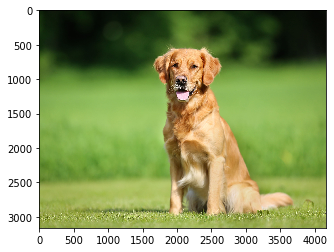

In [4]:
img_path = './images/dog.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

Before the prediction we need to resize the image to fit the input size of VGG. Next we need to convert to numpy array and reshape the data so that it is in "batch" form because the model only accepts input in this form.

In [5]:
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)

import numpy as np
x = np.expand_dims(x, axis=0)

Preprocessing

In [6]:
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)

Prediction

In [7]:
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])


40960/35363 [==================================] - 0s 1us/step
PREDICTION: golden_retriever


Drawing the prediction

Text(0.5, 1.0, 'Top 3 Predictions:')

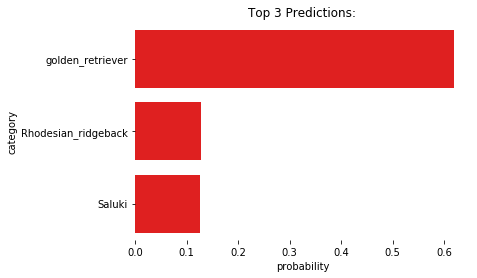

In [8]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

The model has many layers, we can check the layers using the ``summary`` method.

In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

To draw the heatmap we need the prediction, take the last layer and the gradients.

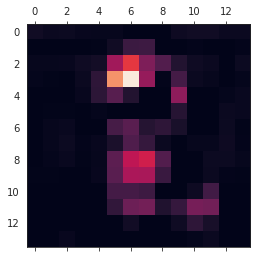

In [10]:
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

## Class Activation Mapping

It looks good, but it looks better if we combine it with the original image.

In [11]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# convert to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# apply heatmap intensity factor
superimposed_img = heatmap * 0.8 + img

In [12]:
# save
output = 'output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

Text(0.5, 1.0, 'golden_retriever')

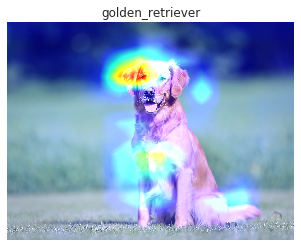

In [13]:
# plot
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

# Play with it



In [17]:
def cam(img_path):
    img=mpimg.imread(img_path)
    plt.imshow(img)    
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    import cv2
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    output = 'output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img=mpimg.imread(output)
    plt.imshow(img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None    

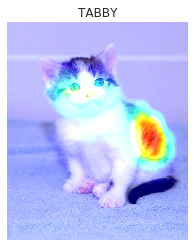

In [18]:
cam('./images/cat1.jpg')

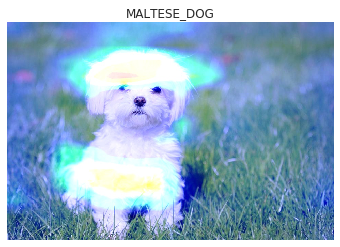

In [19]:
cam('./images/dog2.jpg')